## Notebook for validation of SCENIC predicted networks

In this notebook we will use the STRING and OGEE databases to validate the predicted network.

The STRING database contained information on known protein - protein interactions. This will validate the interactions we predict. 

The OGEE database contains information about gene essensiality. This will validate that the TF's in the network are more essential than expected by chance.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Loading network SCENIC network

In [2]:
network = pd.read_csv('data/regulon_network_links.tsv', sep = '\t', index_col = 0)
network.columns = ['From', 'To', 'Weight']

In [3]:
network.From = [x.strip('(+)') for x in network.From]
network.To = [x.strip('(+)') for x in network.To]
         

In [4]:
network.shape

(4032, 3)

## STRING

### Loading STRING PPi database

In [5]:
#Links table
string_db = pd.read_csv('data/10090.protein.links.v11.0.txt', sep = ' ')

In [6]:
#Table for mapping to gene names
string_names = pd.read_csv('data/10090.protein.info.v11.0.txt', sep = '\t')

In [7]:
mapper = {i:n for i, n in zip(string_names['protein_external_id'], string_names['preferred_name'])}

In [8]:
string_db['protein1'] = string_db.protein1.map(mapper) #mapping to gene names
string_db['protein2'] = string_db.protein2.map(mapper)

### Filter STRING to only contain TF's from SCENIC network

In [10]:
filter_from = {x:x in network.From.tolist() for x in string_db.protein1.unique()}
filter_to = {x:x in network.From.tolist() for x in string_db.protein2.unique()}

In [11]:
string_db_sub = string_db.loc[np.logical_and(np.array(string_db.protein1.map(filter_to)), np.array(string_db.protein2.map(filter_from)))]
string_db_sub.shape

(12198, 3)

In [12]:
network.shape

(4032, 3)

### How many SCENIC inferred links are already included in the string database?

In [13]:
network_pairs = [(x, y) for x,y in zip(network.From, network.To)]
string_pairs = [(x, y) for x,y in zip(string_db_sub.protein1, string_db_sub.protein2)]


network_link_in_string = [x in string_pairs for x in network_pairs]
string_link_in_network = [x in network_pairs for x in string_pairs]


np.sum(network_link_in_string) / len(network_link_in_string)

0.5679563492063492

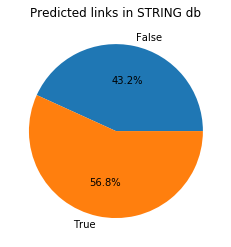

In [16]:
network.groupby('in_network').count().plot(kind = 'pie', y = 'From',autopct='%1.1f%%' )
plt.title('Predicted links in STRING db')
plt.legend().remove()
plt.ylabel('')
plt.savefig('figures/predicted_links_in_string_pie.pdf')

#### Add information to tables

In [15]:
network['in_network'] = network_link_in_string
string_db_sub['in_network'] = string_link_in_network

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Do we predict more high confidence links?

In [17]:
#Sort by combined_score
string_db_sub.sort_values('combined_score', ascending = True, inplace = True)

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


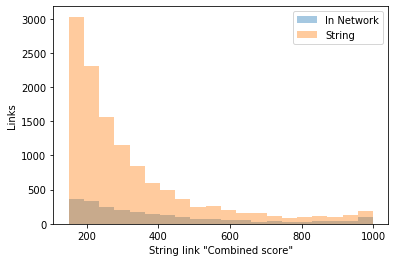

In [18]:
# Show overlap between the STRING and SCENIC links
sns.distplot(string_db_sub[string_db_sub.in_network == True].combined_score, label = 'In Network', kde = False , bins = 20)
sns.distplot(string_db_sub.combined_score , label = 'String' , kde = False, bins = 20)
plt.legend()
plt.ylabel('Links')
plt.xlabel('String link "Combined score"')
plt.savefig('data/predicted_string_links.pdf')

#### What fraction of highly vs. lowly confident links do we predict?

In [19]:
#Divide into 10 quantiles
string_db_sub['quantile'] = pd.qcut(string_db_sub.combined_score, q=10)

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
#Count
percentiles = string_db_sub.groupby(['quantile', 'in_network']).count().reset_index().pivot(index='quantile', columns = 'in_network', values = 'combined_score')

In [21]:
#Calculate fraction of links predicted per quantile
height = percentiles[True] / percentiles.sum(axis = 1)
height = pd.DataFrame(height)
height.columns = ['Fraction']
height['Percentile'] = height.index#range(1,6)

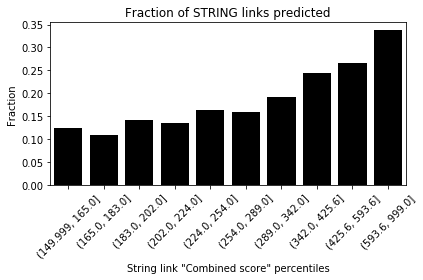

In [22]:
#Plot
ax = sns.barplot(y = 'Fraction', x = 'Percentile', data = height, color = 'k')
plt.title('Fraction of STRING links predicted')
plt.xlabel('String link "Combined score" percentiles')
ax.set_xticklabels(height['Percentile'],rotation=45)
plt.tight_layout()
plt.savefig('figures/predicted_string_links_10percentiles.pdf')


### String score correlation to CSI 

In [23]:
#Load CSI matrix
csi = pd.read_csv('data/integrated_CSI.tsv', sep = '\t')#, index_col = 0)

In [24]:
#Preprocess
csi = pd.melt(csi, id_vars = ['Unnamed: 0'])
csi.columns = ['From', 'To', 'CSI']

csi.From = [x.strip('(+)') for x in csi.From]
csi.To = [x.strip('(+)') for x in csi.To]

In [25]:
#Make indexes identical
string_db_sub.index = [str((f,t)) for f,t in  zip(string_db_sub.protein1, string_db_sub.protein2)]
csi.index = [str((f,t)) for f,t in  zip(csi.From, csi.To)]

In [26]:
#Joined matrix
corr = pd.concat([csi,
           string_db_sub['combined_score'] ], axis = 1).dropna()

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


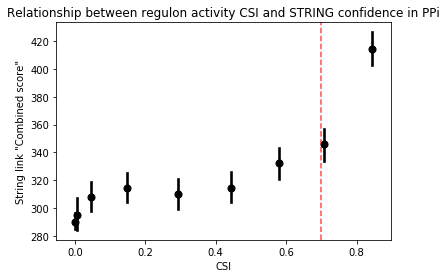

In [28]:
#Plot CSI and Combined score dependency
ax = sns.regplot(x="CSI", y="combined_score", data=corr,
                 x_estimator=np.mean, x_bins = 10 , fit_reg=False, color = 'k', x_ci = 95)
plt.axvline(x = 0.7, color = 'red', alpha = 0.7, linestyle='dashed')
plt.ylabel('String link "Combined score"')
plt.title('Relationship between regulon activity CSI and STRING confidence in PPi')
plt.savefig('figures/string_score_CSI_score.pdf')

#### Save STRING information in network links file

In [139]:
org_network = pd.read_csv('data/Network_links_gephi.csv')

In [142]:
org_network['From'] = [x.strip('(+)') for x in org_network.Source]
org_network['To'] = [x.strip('(+)') for x in org_network.Target]

In [107]:
network_pairs = [(x, y) for x,y in zip(org_network.From, org_network.To)]


network_link_in_string = [x in string_pairs for x in network_pairs]

In [108]:
mapper = {True:'In_string', False:'Not_in_string'}

In [109]:
org_network['In_string'] = network_link_in_string
org_network['In_string_str'] = [mapper[x] for x in network_link_in_string]

In [110]:
org_network.to_csv('data/links_string_in_network.csv', index = False)

## OGEE

### Loading the OGEE essensiality database

In [29]:
ogee = pd.read_csv('data/gene_essentiality.txt', sep = '\t')

In [30]:
genes = pd.read_csv('data/genes.txt', sep = '\t')

In [33]:
gene_map = {ids:gene for ids, gene in zip(genes.locus, genes.symbols)} #map between locus and gene name

In [34]:
ogee['symbol'] = ogee.locus.map(gene_map) #map between locus and gene name

In [35]:
#Subset to only mouse genes
ogee = ogee[ogee.sciName == 'Mus musculus']

In [36]:
# Drop NA's
ogee_sub = ogee[['symbol','essential']].dropna()

In [39]:
ogee_sub.index = ogee_sub.symbol

### Loading network features

In [47]:
#Load network features from Gephi output
network_stats = pd.read_csv('data/Network_stats.csv')

In [32]:
#Make names compatible
network_stats.Id = [x.strip('(+)') for x in network_stats.Id]
network_stats.Label = [x.strip('(+)') for x in network_stats.Label]
         

In [38]:
network_stats.index = network_stats.Id

In [37]:
network_stats.shape

(174, 18)

### Join the databases

In [40]:
merge = pd.concat([ogee_sub, network_stats.dropna(axis = 1)], axis = 1).dropna()

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


### Plot assosiation with network features

In [80]:
merge.columns

Index(['symbol', 'essential', 'Id', 'Label', '0', 'Degree', 'Weighted Degree',
       'Eccentricity', 'closnesscentrality', 'harmonicclosnesscentrality',
       'betweenesscentrality', 'Authority', 'Hub', 'modularity_class',
       'pageranks', 'componentnumber', 'clustering', 'triangles',
       'eigencentrality', 'quantile'],
      dtype='object')

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


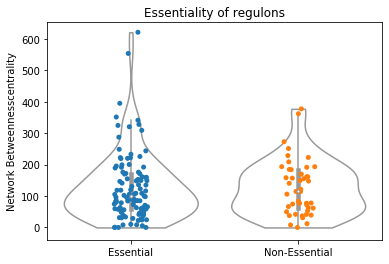

In [41]:
#Plot features to estimate their impact on essensiality
sns.stripplot(x = 'essential', y = 'betweenesscentrality', data = merge )
sns.violinplot(x = 'essential', y = 'betweenesscentrality', data = merge , color = 'w', zorder = 10, cut = 0, scale = 'width')
plt.title('Essentiality of regulons')
plt.xlabel('')
plt.xticks([0,1], ['Essential', 'Non-Essential'])
plt.ylabel('Network Betweennesscentrality')
plt.savefig('data/regulon_essentiality_OGEE_betweenness.pdf')

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


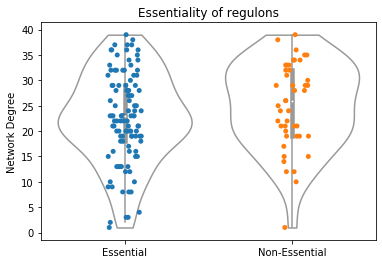

In [42]:
sns.stripplot(x = 'essential', y = 'Degree', data = merge )
sns.violinplot(x = 'essential', y = 'Degree', data = merge , color = 'w', zorder = 10, cut = 0, scale = 'width')
plt.title('Essentiality of regulons')
plt.xlabel('')
plt.xticks([0,1], ['Essential', 'Non-Essential'])
plt.ylabel('Network Degree')
plt.savefig('data/regulon_essentiality_OGEE_degree.pdf')

### Important regulons based on network features

In [63]:
network_stats.columns

Index(['Id', 'Label', 'timeset', '0', 'Degree', 'Weighted Degree',
       'Eccentricity', 'closnesscentrality', 'harmonicclosnesscentrality',
       'betweenesscentrality', 'Authority', 'Hub', 'modularity_class',
       'pageranks', 'componentnumber', 'clustering', 'triangles',
       'eigencentrality'],
      dtype='object')

In [64]:
network_stats.index = [x.strip('(+)') for x in network_stats.Label]

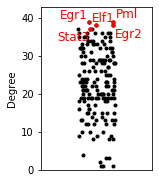

In [119]:
#Plot the top most important regulons, based on network features
from math import ceil, floor
from adjustText import adjust_text
to_plot = 'Degree'
max_n = network_stats.shape[0]
top_n = 5
data = network_stats[to_plot].sort_values(ascending=False)[0:max_n]

_, ax = plt.subplots(1, 1, figsize=(2, 3))
x = np.random.sample(len(data))
ax.plot(x, data, 'k.')
ax.set_ylim([floor(data.min()*100.0)/100.0, ceil(data.max()*100.0)/100.0])
ax.set_ylabel(to_plot)
ax.set_xlabel('')
ax.set_xticks([]) 
ax.set_xticklabels([])
ax.set_ylim(0, np.max(data)*1.1)

font = {
            'color':  'red',
            'weight': 'normal',
            'size':12 ,
        }
texts = []
for idx, (x_val, regulon_name, val) in enumerate(zip(x, data[0:top_n].index, data[0:top_n].values)):
    ax.plot([x_val, x_val], [val, val], 'r.')
    texts.append(ax.text(x_val, val , regulon_name, fontdict=font, horizontalalignment='left', verticalalignment='center'))
ax.set_xlim(-1, 2)
adjust_text(texts)
plt.savefig('figures/{}_important_genes.pdf'.format(to_plot))


### Essentiality enrichment in SCENIC network

In [233]:
m = merge.groupby(['0', 'essential']).count().reset_index().pivot(index='0', columns = 'essential', values = 'Id').replace(np.NaN, 0).values





In [235]:
#Use R to show regulon assosiation to essensiality
import numpy as np
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

stats = importr('stats')

res = stats.fisher_test(m)
print('p-value: {}'.format(res[0][0]))

p-value: 0.4889634673282357


In [9]:
ogee.groupby('essential').count()

NameError: name 'ogee' is not defined

In [77]:
merge.groupby('essential').count()

,symbol,Id,Label,0,Degree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,Authority,Hub,modularity_class,pageranks,componentnumber,clustering,triangles,eigencentrality
essential,,,,,,,,,,,,,,,,,,
E,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109
NE,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45


In [86]:
m = np.array([[4341, 109 ], 
              [4701, 45 ]])

In [88]:
m

array([[4341,  109],
       [4701,   45]])

#### Run fishers excact test

In [89]:
import numpy as np
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

stats = importr('stats')

res = stats.fisher_test(m)
print('p-value: {}'.format(res[0][0]))

p-value: 1.922694927508917e-08


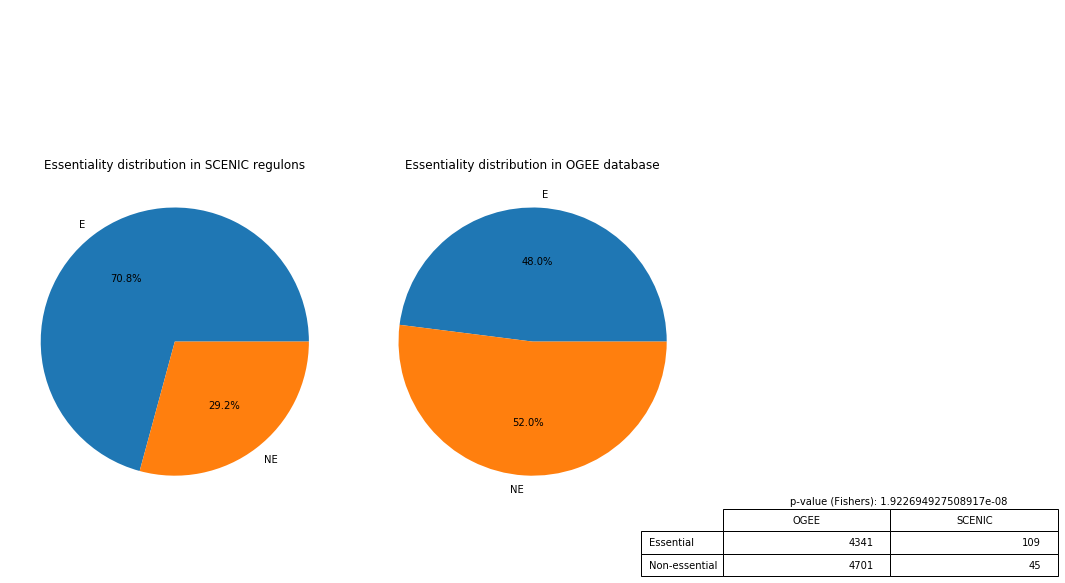

In [132]:
fig, axs = plt.subplots(1, 3, figsize = (15,5))
axs = np.ravel(axs)
merge.groupby('essential').count().plot(kind = 'pie', y = 'symbol',autopct='%1.1f%%', ax = axs[0] )
axs[0].set_title('Essentiality distribution in SCENIC regulons')
axs[0].legend().remove()
axs[0].set_ylabel('')



ogee.groupby('essential').count().plot(kind = 'pie', y = 'locus',autopct='%1.1f%%', ax = axs[1] )
axs[1].set_title('Essentiality distribution in OGEE database')
axs[1].legend().remove()
axs[1].set_ylabel('')

pd.plotting.table(axs[2], pd.DataFrame(m, columns = ['OGEE', 'SCENIC'], index = ['Essential', 'Non-essential']))
axs[2].set_axis_off()
plt.tight_layout()
axs[2].text(0.2, 0.01, 'p-value (Fishers): {}'.format(res[0][0]))

box = axs[2].get_position()
axs[2].set_position([box.x0, box.y0, box.width, box.height*1.5])


plt.savefig('figures/regulon_vs_ogee_essential_fisher_pie.pdf')

#### Save OGEE essentiality in network file

In [137]:
network_stats_org = pd.read_csv('data/Network_stats.csv')

In [36]:
merge = pd.concat([ogee_sub, network_stats.dropna(axis = 1)], axis = 1).loc[network_stats.index]
merge.essential = merge.essential.replace(np.NaN, 'NaN')

/work/sduknn/Andreas/bin/python_deps/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [37]:
network_stats_org['essential'] = merge.essential.tolist()

In [40]:
network_stats_org.to_csv('data/network_essential.csv', index = False)